# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**

## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style = 'whitegrid')


# 1. Data Validation

## A. Check descriptive statistics, duplicated data, and missing values

The dataset contains 947 rows and 8 features. The features are described as follows:

- recipe: Numeric, unique identifier of recipe. No cleaning is needed.
- calories: Numeric, number of calories. 52 missing values, will be imputed using mean or median.
- carbohydrate: Numeric, amount of carbohydrates in grams. 52 missing values, will be imputed using mean or median.
- sugar: Numeric, amount of sugar in grams. 52 missing values, will be imputed using mean or median.
- protein: Numeric, amount of protein in grams. 52 missing values, will be imputed using mean or median.
- category: 10 categories but the data have 11 categories. Need to be checked and synchronized.
- servings: Should be numeric but there are string values, number of servings for the recipe. Need to be synchronized.
- high_traffic: categorical but there are only one category which is 'High' and the rest is null. Need to replace null value, assumed that the rest is "Low"

In [304]:
df = pd.read_csv('./data/recipe_site_traffic_2212.csv')
display(df)

print("Data Types: ")
display(df.info())


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Data Types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


None

### a. Fixing Data Types

The servings column data type is wrong as it should be an integer type, so I will change it. But, there is a problem because servings have string values like '4 as a snack' and '6 as a snack' so I can't just change the data type, I need to encode the values first.

In [305]:
df['servings'].value_counts()


servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [306]:
replacement_dict = {'4 as a snack': '4', '6 as a snack': '6'}
df['servings'].replace(replacement_dict, inplace=True)
print(df['servings'].value_counts())
df['servings'] = df['servings'].astype('category')


servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64


In [307]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      947 non-null    object  
 6   servings      947 non-null    category
 7   high_traffic  574 non-null    object  
dtypes: category(1), float64(4), int64(1), object(2)
memory usage: 53.0+ KB


### b. Data Exploration With Descriptive Statistics

In [308]:
print("Descriptive Statistics: ")
display(df.describe())
display(df.describe(include=['O']))


Descriptive Statistics: 


,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


,category,high_traffic
count,947,574
unique,11,1
top,Breakfast,High
freq,106,574


From the nominal (text) statistical description above, I can see anomalies in both columns (category and high_traffic). First, The category column have 11 unique values as opposed to the data description that states the column have 10 unique values, so I need to encode the anomaly to make the unique values to ten and match the description. 

In [309]:
df['category'].value_counts()


category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

In [310]:
replacement_dict = {'Chicken Breast': 'Chicken'}
df['category'].replace(replacement_dict, inplace=True)
df['category'] = df['category'].astype('category')
print(df['category'].value_counts())


category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Dessert           83
Vegetable         83
Meat              79
One Dish Meal     71
Name: count, dtype: int64


I replaced the 'Chicken Breast' value to 'Chicken' with the assumption that 'Chicken' category consists all of the chicken parts in the meal.

Then regarding the 'high_traffic' column, it only have one unique value which is 'high' traffic and null in the other data. So it's safe to assume that the other is 'low' traffic and make it a binary category. I can't assume that there is also 'medium' traffic because I don't know what the threshold is for 'medium' traffic.	

In [311]:
df['high_traffic'].value_counts()


high_traffic
High    574
Name: count, dtype: int64

Fill the null values with 'low' in the 'high_traffic' column and change the data type to categorical. 

In [312]:
df['high_traffic'].fillna('Low', inplace=True)
df['high_traffic'] = df['high_traffic'].astype('category')
df['high_traffic'].value_counts()


high_traffic
High    574
Low     373
Name: count, dtype: int64

In [313]:
print("Missing Values: ")
display(df.isna().sum())

print("Missing Value Percentage: ")
display(df.isna().sum() / len(df))


Missing Values: 


recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

Missing Value Percentage: 


recipe          0.00000
calories        0.05491
carbohydrate    0.05491
sugar           0.05491
protein         0.05491
category        0.00000
servings        0.00000
high_traffic    0.00000
dtype: float64

There are missing values in calories, carbohydrate, sugar, protein. The columns with missing values have distributions that are very skewed (right-skewed) and have so many outliers so, I imputed it with median because median is less sensitive to outliers than mean. I will handle the outlier later.

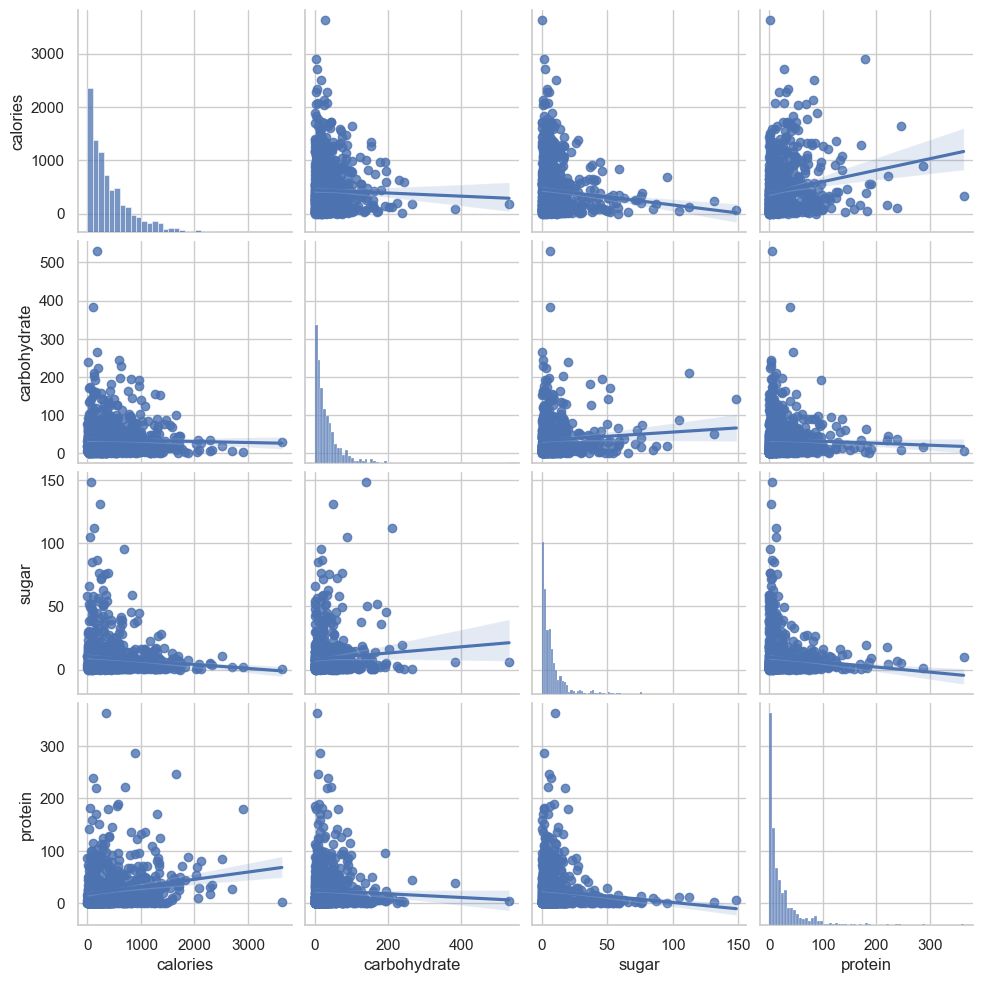

In [314]:
sns.pairplot(df.loc[:, ['calories', 'carbohydrate', 'sugar', 'protein']], kind='reg');


In [315]:
calories_mean, calories_median = df['calories'].mean(), df['calories'].median()
carbohydrate_mean, carbohydrate_median = df['carbohydrate'].mean(), df['carbohydrate'].median()
sugar_mean, sugar_median = df['sugar'].mean(), df['sugar'].median()
protein_mean, protein_median = df['protein'].mean(), df['protein'].median()

df['calories'].fillna(calories_median, inplace=True)
df['carbohydrate'].fillna(carbohydrate_median, inplace=True)
df['sugar'].fillna(sugar_median, inplace=True)
df['protein'].fillna(protein_median, inplace=True)


In [316]:
print("Missing Values: ")
display(df.isna().sum())


Missing Values: 


recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [317]:
print("Duplicated Recipe Values: ")
display(df.duplicated(subset='recipe').sum())


Duplicated Recipe Values: 


0

In [318]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      947 non-null    float64 
 2   carbohydrate  947 non-null    float64 
 3   sugar         947 non-null    float64 
 4   protein       947 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    category
 7   high_traffic  947 non-null    category
dtypes: category(3), float64(4), int64(1)
memory usage: 40.6 KB


In [319]:
display(df.describe())
display(df.describe(include=['category']))


,recipe,calories,carbohydrate,sugar,protein
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283
std,273.519652,441.673556,42.836191,14.306785,35.486699
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,576.225000,42.590000,9.285000,28.530000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


,category,servings,high_traffic
count,947,947,947
unique,10,4,2
top,Chicken,4,High
freq,172,391,574


# 2. Exploratory Data Analysis (EDA)

## A. Deep dive into outliers analysis by using histograms and boxplots.

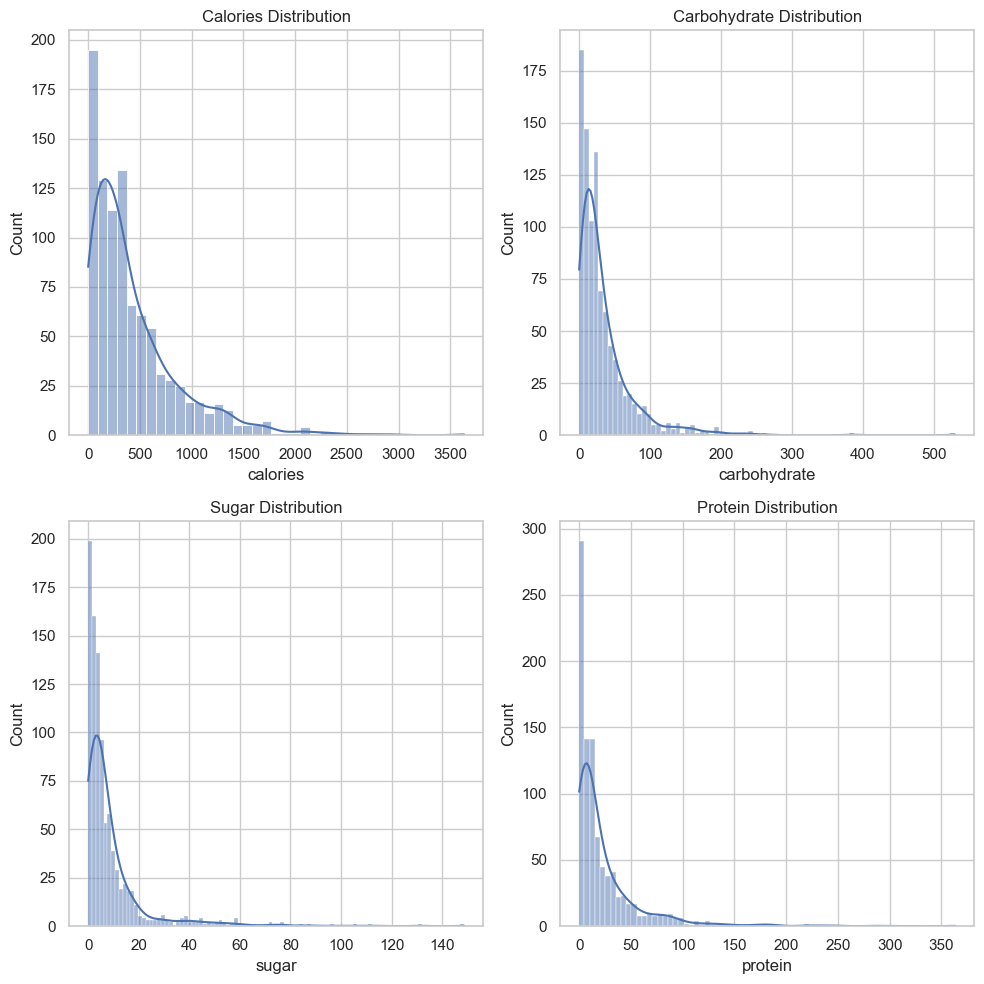

In [320]:
numcols = df.select_dtypes(include='float').columns
num_rows = len(numcols)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.histplot(data=df, x='calories', kde=True, ax=axes[0, 0])
sns.histplot(data=df, x='carbohydrate', kde=True, ax=axes[0, 1])
sns.histplot(data=df, x='sugar', kde=True, ax=axes[1, 0])
sns.histplot(data=df, x='protein', kde=True, ax=axes[1, 1])

axes[0, 0].set_title('Calories Distribution')
axes[0, 1].set_title('Carbohydrate Distribution')
axes[1, 0].set_title('Sugar Distribution')
axes[1, 1].set_title('Protein Distribution')

plt.tight_layout()
plt.show()


Based on the numeric columns distribution (Calories, Carbohydrate, Sugar, and Protein), the majority of calories amount is less than 1750 calories, for carbohydrate amount is less than 100 grams, for sugar is less than 20 grams, and for protein is less than 100 grams. Any more than those values can be considered as outliers.

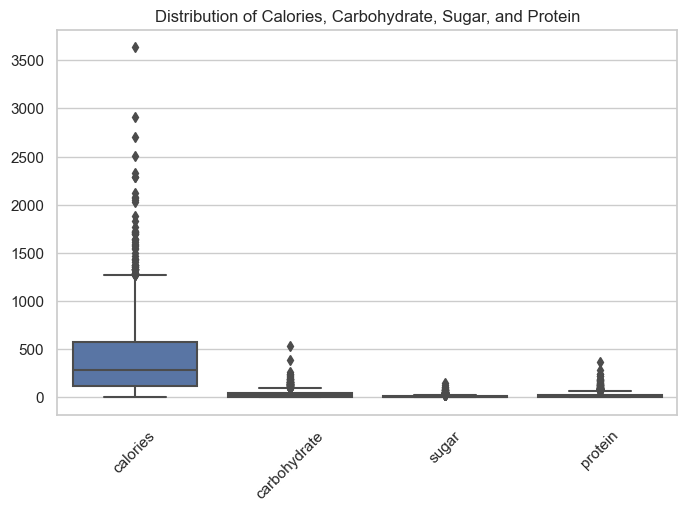

In [321]:
plt.figure(figsize=(8,5))
sns.boxplot(df[numcols])
plt.xticks(rotation=45)
plt.title('Distribution of Calories, Carbohydrate, Sugar, and Protein')
plt.show()


Based on the histograms and boxplots, it is obvious that there are outliers in the numeric columns. In the histogram, it can be seen that the dataset mostly consisted of lower values, so it showed us a right-skewed distribution. Because of these outliers, median is more suited than mean for the aggregation method because median is less sensitive to outliers than mean.

In [322]:
grouped_median = df.groupby('category')[numcols].median()
display(grouped_median)


,calories,carbohydrate,sugar,protein
category,,,,
Beverages,126.455,11.250,8.075,0.410
Breakfast,229.380,28.420,4.830,11.685
Chicken,361.255,16.945,4.035,32.535
Dessert,288.550,33.940,20.990,5.080
Lunch/Snacks,343.260,29.100,3.380,10.850
Meat,410.920,20.960,4.340,25.210
One Dish Meal,374.750,24.890,4.160,25.730
Pork,308.500,21.480,4.550,22.905
Potato,288.550,31.115,2.935,6.420


In [323]:
def remove_outliers_iqr(df, columns):
	for col in columns:
		q1 = df[col].quantile(0.25)
		q3 = df[col].quantile(0.75)
		iqr = q3 - q1
		lower_bound = q1 - 1.5 * iqr
		upper_bound = q3 + 1.5 * iqr
		df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
	return df

df = remove_outliers_iqr(df, numcols)


In [324]:
df


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,288.55,21.48,4.55,10.80,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,High
943,944,288.55,21.48,4.55,10.80,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


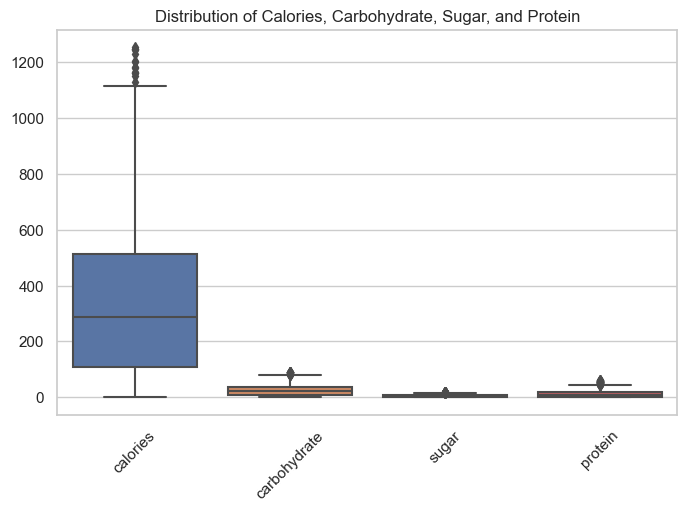

In [325]:
plt.figure(figsize=(8,5))
sns.boxplot(df[numcols])
plt.xticks(rotation=45)
plt.title('Distribution of Calories, Carbohydrate, Sugar, and Protein')
plt.show()


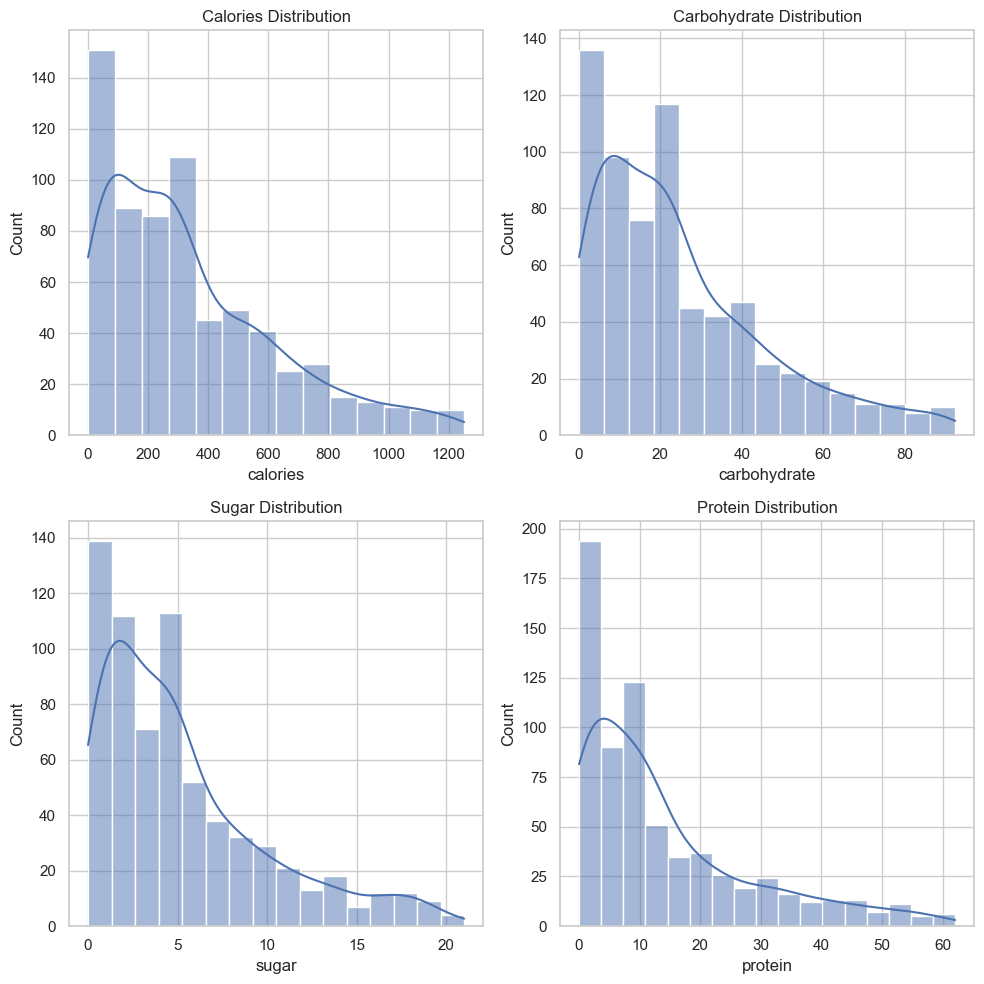

In [326]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.histplot(data=df, x='calories', kde=True, ax=axes[0, 0])
sns.histplot(data=df, x='carbohydrate', kde=True, ax=axes[0, 1])
sns.histplot(data=df, x='sugar', kde=True, ax=axes[1, 0])
sns.histplot(data=df, x='protein', kde=True, ax=axes[1, 1])

axes[0, 0].set_title('Calories Distribution')
axes[0, 1].set_title('Carbohydrate Distribution')
axes[1, 0].set_title('Sugar Distribution')
axes[1, 1].set_title('Protein Distribution')

plt.tight_layout()
plt.show()


The major outliers are pretty much gone, but there are several outliers left. I think removing all outliers may not always be the best approach as it may result in loss of important information.

### Charts

In [327]:
df.groupby('category')['high_traffic'].value_counts()


category       high_traffic
Beverages      Low             75
               High             4
Breakfast      Low             56
               High            28
Chicken        Low             62
               High            46
Dessert        High            22
               Low             12
Lunch/Snacks   High            45
               Low             26
Meat           High            41
               Low             12
One Dish Meal  High            34
               Low             15
Pork           High            50
               Low              4
Potato         High            68
               Low              5
Vegetable      High            76
               Low              1
Name: count, dtype: int64

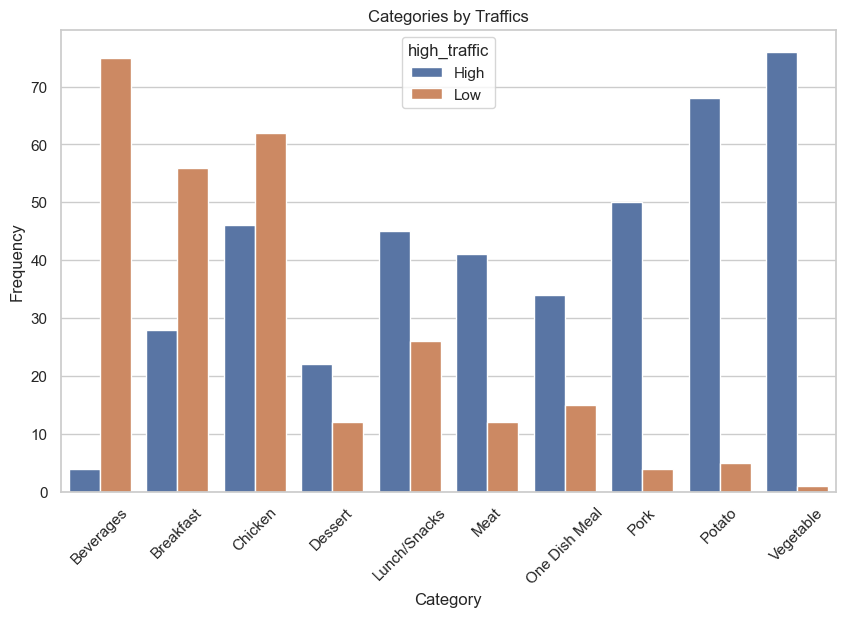

In [328]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation= 45)
plt.yticks(np.arange(0, 100, 10))

sns.countplot(x='category', hue='high_traffic', data=df)

plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Categories by Traffics')
plt.show()


Then, based on the plot above, Recipes in certain categories have higher traffic than other categories. 

It can be inferred that the top three highest traffic categories are Vegetable, Potato, and Pork while Beverages, Breakfast, and Chicken are the bottom three lowest traffic categories.

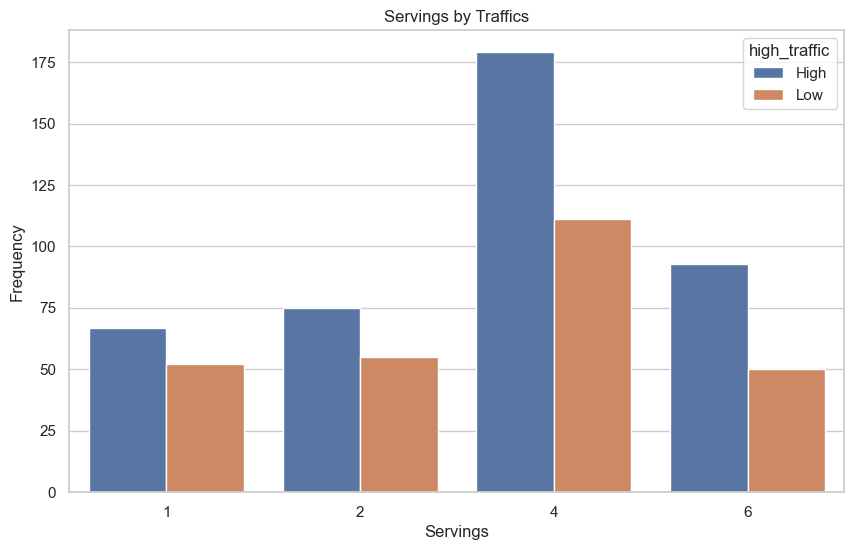

In [329]:
plt.figure(figsize=(10, 6))

sns.countplot(x='servings', hue='high_traffic', data=df)

plt.xlabel('Servings')
plt.ylabel('Frequency')
plt.title('Servings by Traffics')
plt.show()


From that bar plot above, it can be inferred that servings of 4 an 6 have higher traffic rate than 1 and 2 servings.

In [330]:
df.groupby('high_traffic')[numcols].agg(['mean', 'median']).reset_index()


high_traffic    calories          carbohydrate            sugar         \
                      mean   median         mean median      mean median   
0         High  365.157391  288.550    25.653768  21.48  4.945145   4.36   
1          Low  306.003022  261.105    23.894328  18.74  5.830560   4.39   

     protein         
        mean median  
0  15.043382  10.80  
1  12.290075   7.25

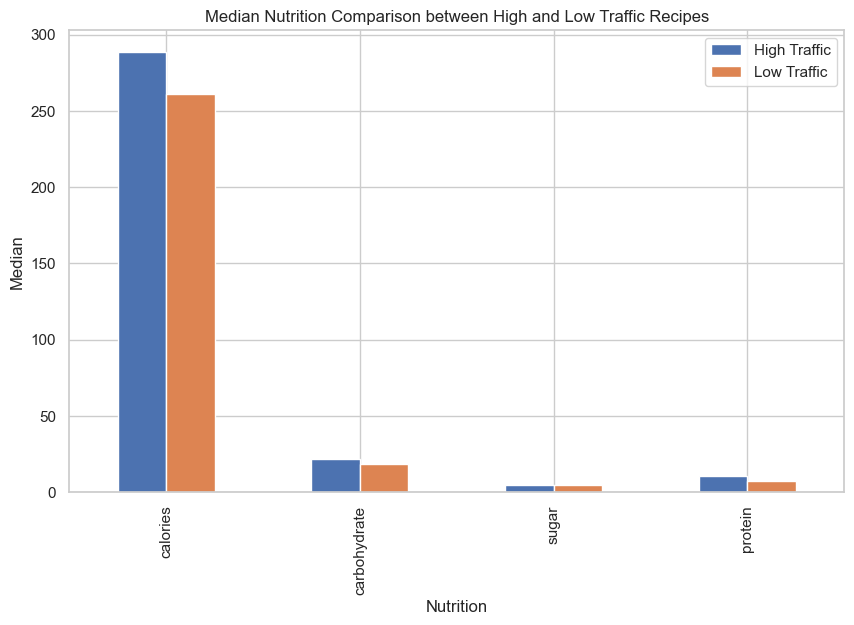

In [331]:
high_traffic_df = df[df['high_traffic'] == "High"]
low_traffic_df = df[df['high_traffic'] == "Low"]


traffics_mean_df = pd.DataFrame({'High Traffic': high_traffic_df[numcols].median(), 'Low Traffic': low_traffic_df[numcols].median()})

traffics_mean_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Nutrition')
plt.ylabel('Median')
plt.title('Median Nutrition Comparison between High and Low Traffic Recipes')
plt.show()


This bar plot shows the median values between certain nutrition that generate high website traffic vs low website traffic

# 3. Model Development and Evaluation

## A. Encode Categorical Columns

In [332]:
df


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,288.55,21.48,4.55,10.80,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,High
943,944,288.55,21.48,4.55,10.80,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


## One-Hot Encoding

In [333]:
encoded_category_col = pd.get_dummies(df["category"], dtype='int64')

df_encoded = pd.concat([df, encoded_category_col], axis=1)

df_encoded = df_encoded.drop("category", axis=1)

print(df_encoded.head())
print(df_encoded.info())


   recipe  calories  carbohydrate  sugar  protein servings high_traffic  \
0       1    288.55         21.48   4.55    10.80        6         High   
1       2     35.48         38.56   0.66     0.92        4         High   
2       3    914.28         42.68   3.09     2.88        1          Low   
4       5     27.05          1.85   0.80     0.53        4          Low   
5       6    691.15          3.46   1.65    53.93        2         High   

   Beverages  Breakfast  Chicken  Dessert  Lunch/Snacks  Meat  One Dish Meal  \
0          0          0        0        0             0     0              0   
1          0          0        0        0             0     0              0   
2          0          1        0        0             0     0              0   
4          1          0        0        0             0     0              0   
5          0          0        0        0             0     0              1   

   Pork  Potato  Vegetable  
0     1       0          0  
1     0   

## Normalize Data Distribution

The data should be normally distributed to get better classification results. The data is normalized by using the Box-Cox Transformation method and by transforming the data, the skewness can be lowered and make the data distribution become normal (bell-shaped curve).

In [334]:

from scipy.stats import boxcox, yeojohnson
for col in numcols:
	df_encoded[col], _ = boxcox(df_encoded[col] + 1)
df_encoded


,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
0,1,17.412458,4.885625,1.754952,2.957852,6,High,0,0,0,0,0,0,0,1,0,0
1,2,7.084905,6.304294,0.510377,0.683608,4,High,0,0,0,0,0,0,0,0,1,0
2,3,27.229836,6.576114,1.436266,1.495684,1,Low,0,1,0,0,0,0,0,0,0,0
4,5,6.224173,1.210913,0.592578,0.438419,4,Low,1,0,0,0,0,0,0,0,0,0
5,6,24.479661,1.843135,0.987777,5.402197,2,High,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,942,14.592886,8.602353,1.108534,3.980142,4,High,0,0,1,0,0,0,0,0,0,0
943,944,17.412458,4.885625,1.754952,2.957852,2,High,0,0,0,0,0,0,0,0,1,0
944,945,27.646661,5.617815,1.551807,3.292052,2,High,0,0,0,0,0,0,0,1,0,0
945,946,16.871358,6.108260,0.684414,2.590736,6,High,0,0,0,0,0,0,0,0,1,0


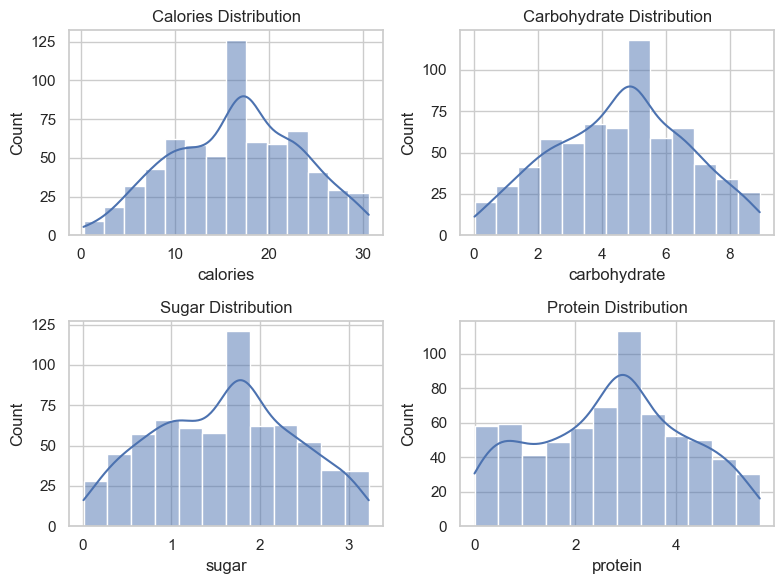

In [335]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

sns.histplot(data=df_encoded, x='calories', kde=True, ax=axes[0, 0])
sns.histplot(data=df_encoded, x='carbohydrate', kde=True, ax=axes[0, 1])
sns.histplot(data=df_encoded, x='sugar', kde=True, ax=axes[1, 0])
sns.histplot(data=df_encoded, x='protein', kde=True, ax=axes[1, 1])

axes[0, 0].set_title('Calories Distribution')
axes[0, 1].set_title('Carbohydrate Distribution')
axes[1, 0].set_title('Sugar Distribution')
axes[1, 1].set_title('Protein Distribution')

plt.tight_layout()
plt.show()


After applying the Box-Cox transformation method, the data is distributed better and seemed towards a normal distribution (bell-shaped curve) 

## B. Model Building

Predicting the recipes is a classification problem in machine learning. I am choosing the Decision Tree Classifier model not only it is a great model, but we also can calculate the feature importance later on. I also choose some other models for comparison such as SVM.

For the evaluation, as per instruction I choose to use **accuracy score**, and **recall score** to evaluate the model because the model needs to correctly predict high traffic recipes 80% of the time to increase the website traffic by 40%.

In [336]:
X = df_encoded.drop(columns=['recipe', 'high_traffic'])
y = df_encoded['high_traffic']


In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(511, 15) (171, 15)
(511,) (171,)


### Decision Tree

In [338]:
Baseline_DT = DecisionTreeClassifier(random_state=42)

Baseline_DT.fit(X_train, y_train)

y_pred_DT = Baseline_DT.predict(X_test)



Accuracy  0.7309941520467836
Precision  0.7685185185185185
Recall  0.7980769230769231
F-1 Score  0.7830188679245284
              precision    recall  f1-score   support

        High       0.77      0.80      0.78       104
         Low       0.67      0.63      0.65        67

    accuracy                           0.73       171
   macro avg       0.72      0.71      0.71       171
weighted avg       0.73      0.73      0.73       171

[[83 21]
 [25 42]]


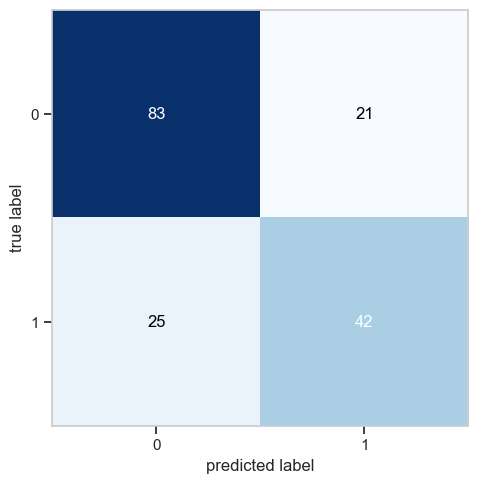

In [339]:
print('\nAccuracy ',accuracy_score(y_test, y_pred_DT))
print('Precision ',precision_score(y_test, y_pred_DT, pos_label='High'))
print('Recall ',recall_score(y_test, y_pred_DT, pos_label='High'))
print('F-1 Score ',f1_score(y_test, y_pred_DT, pos_label='High'))

print(classification_report(y_test, y_pred_DT))

cm_Baseline_DT = confusion_matrix(y_test, y_pred_DT, labels=['High', 'Low'])
print(cm_Baseline_DT)

plot_confusion_matrix(conf_mat=cm_Baseline_DT, figsize=(5,5))
plt.tight_layout()
plt.show()


### Decision Tree With Grid Search CV

In [340]:
param_grid = {
    'max_depth' : [17, 15, 14, 10, 5, 4, 3, None],
    'min_samples_split' : [8, 9, 10],
    'min_samples_leaf' : [2, 3, 4,5],
    'ccp_alpha' :[0.01, 0.02, 0.016, 0.1, 0, 0.001],
    'criterion' :['gini', 'entropy']
}

GridSearch_DT = GridSearchCV(Baseline_DT, param_grid=param_grid, cv=10, scoring='accuracy')
GridSearch_DT.fit(X_train, y_train)
y_pred_GridSearch_DT = GridSearch_DT.predict(X_test)


In [341]:
GridSearch_DT.best_params_


{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

In [342]:
GridSearch_DT.best_estimator_


DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       min_samples_leaf=2, min_samples_split=8,
                       random_state=42)

Training Accuracy:  0.7906066536203522

Accuracy  0.7894736842105263
Precision  0.7982456140350878
Recall  0.875
F-1 Score  0.834862385321101
              precision    recall  f1-score   support

        High       0.80      0.88      0.83       104
         Low       0.77      0.66      0.71        67

    accuracy                           0.79       171
   macro avg       0.79      0.77      0.77       171
weighted avg       0.79      0.79      0.79       171

[[91 13]
 [23 44]]


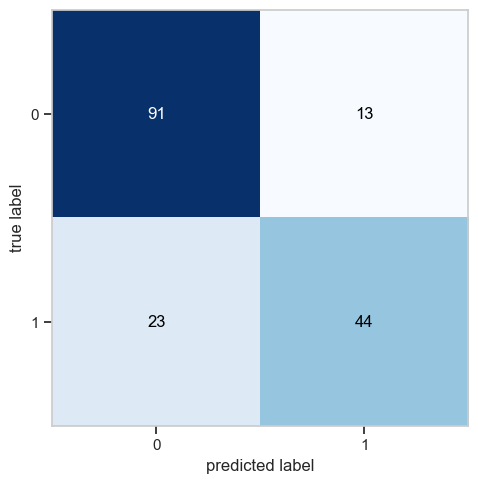

In [343]:
print("Training Accuracy: ", GridSearch_DT.score(X_train, y_train))

print('\nAccuracy ',accuracy_score(y_test, y_pred_GridSearch_DT))
print('Precision ',precision_score(y_test, y_pred_GridSearch_DT, pos_label='High'))
print('Recall ',recall_score(y_test, y_pred_GridSearch_DT, pos_label='High'))
print('F-1 Score ',f1_score(y_test, y_pred_GridSearch_DT, pos_label='High'))

print(classification_report(y_test, y_pred_GridSearch_DT))

cm_GridSearch_DT = confusion_matrix(y_test, y_pred_GridSearch_DT)
print(cm_GridSearch_DT)

plot_confusion_matrix(conf_mat=cm_GridSearch_DT, figsize=(5,5))
plt.tight_layout()
plt.show()


### Support Vector Machine (SVM)


Accuracy  0.8070175438596491
Precision  0.8317757009345794
Recall  0.8557692307692307
F-1 Score  0.8436018957345972



Cross Validation Accuracy Score Average:  0.7650452488687783

               precision    recall  f1-score   support

        High       0.83      0.86      0.84       104
         Low       0.77      0.73      0.75        67

    accuracy                           0.81       171
   macro avg       0.80      0.79      0.80       171
weighted avg       0.81      0.81      0.81       171

[[89 15]
 [18 49]]


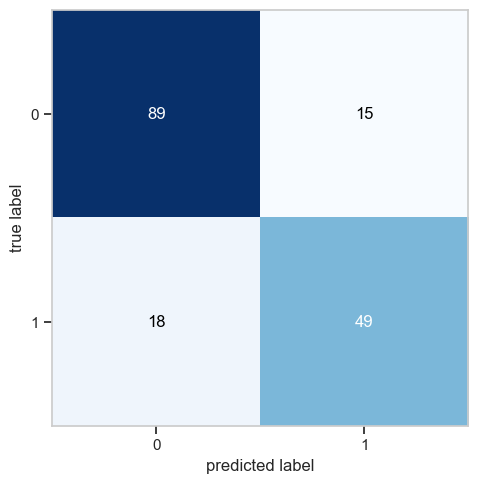

In [344]:
Baseline_SVM = SVC(kernel='linear', probability=True)
Baseline_SVM.fit(X_train, y_train)

y_pred_SVM = Baseline_SVM.predict(X_test)

print('\nAccuracy ',accuracy_score(y_test, y_pred_SVM))
print('Precision ',precision_score(y_test, y_pred_SVM, pos_label='High'))
print('Recall ',recall_score(y_test, y_pred_SVM, pos_label='High'))
print('F-1 Score ',f1_score(y_test, y_pred_SVM, pos_label='High'))

print("\nCross Validation Accuracy Score Average: ", cross_val_score(Baseline_SVM, X_train, y_train, cv=10, scoring='accuracy').mean())

print("\n",classification_report(y_test, y_pred_SVM))

cm_Baseline_SVM = confusion_matrix(y_test, y_pred_SVM)
print(cm_Baseline_SVM)

plot_confusion_matrix(conf_mat=cm_Baseline_SVM, figsize=(5,5))
plt.tight_layout()
plt.show()


### Support Vector Machine (SVM) With Grid Search CV

In [345]:
classifier = SVC()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear']
             }

GridSearch_SVM = GridSearchCV(classifier, param_grid, cv=10, refit = True, scoring='accuracy')
GridSearch_SVM.fit(X_train, y_train)
y_pred_GridSearch_SVM = GridSearch_SVM.predict(X_test)

print(GridSearch_SVM.best_params_)
print(GridSearch_SVM.best_estimator_)


{'C': 0.1, 'kernel': 'linear'}
SVC(C=0.1, kernel='linear')


Training Accuracy:  0.7651663405088063

Accuracy  0.8070175438596491
Precision  0.8317757009345794
Recall  0.8557692307692307
F-1 Score  0.8436018957345972
              precision    recall  f1-score   support

        High       0.83      0.86      0.84       104
         Low       0.77      0.73      0.75        67

    accuracy                           0.81       171
   macro avg       0.80      0.79      0.80       171
weighted avg       0.81      0.81      0.81       171

[[89 15]
 [18 49]]


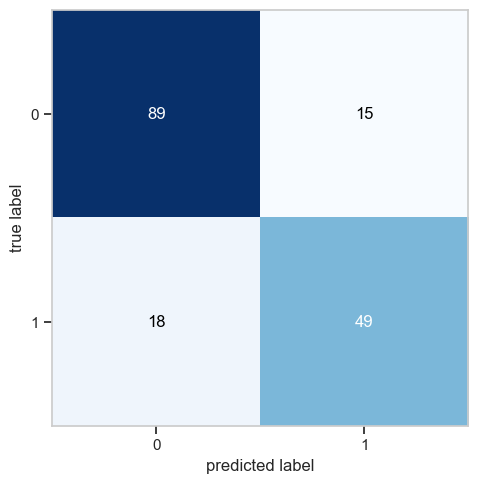

In [346]:
print("Training Accuracy: ", GridSearch_SVM.score(X_train, y_train))

print('\nAccuracy ',accuracy_score(y_test, y_pred_GridSearch_SVM))
print('Precision ',precision_score(y_test, y_pred_GridSearch_SVM, pos_label='High'))
print('Recall ',recall_score(y_test, y_pred_GridSearch_SVM, pos_label='High'))
print('F-1 Score ',f1_score(y_test, y_pred_GridSearch_SVM, pos_label='High'))

print(classification_report(y_test, y_pred_GridSearch_SVM))

cm_GridSearch_SVM = confusion_matrix(y_test, y_pred_GridSearch_SVM)
print(cm_GridSearch_SVM)

plot_confusion_matrix(conf_mat=cm_GridSearch_SVM, figsize=(5,5))
plt.tight_layout()
plt.show()


### I built a decision tree model as a reference model to be compared with SVM model. Every model have their baseline versions and Grid Search CV versions. The baseline version also have cross validation mean accuracy score as an additional metric, the folds in both cross validation and Grid Search CV have been set to 10.

The models yielded **accuracy** scores as follows:
1. Baseline Decision Tree: 0.7309941520467836 (**73.10%**)
2. Decision Tree With Grid Search CV: 0.7894736842105263 (**78.95%**)
3. Baseline SVM: 0.8070175438596491 (**80.70%**)
4. SVM With Grid Search CV: 0.8070175438596491 (**80.70%**)

The models yielded **recall** scores as follows:
1. Baseline Decision Tree: 0.7980769230769231 (**79.81%**)
2. Decision Tree With Grid Search CV: 0.875 (**87.50%**)
3. Baseline SVM: 0.8557692307692307 (**85.58%**)
4. SVM With Grid Search CV: 0.8557692307692307 (**85.58%**)

As you can see, the highest **accuracy** scores are the baseline SVM Model and the SVM model applied with Grid Search CV. The models (both Decision Tree and SVM) when applied with Grid Search CV had higher accuracy scores than the baseline models because the hyperparameters had been tuned through multiples times using Grid Search CV.

But our focus as the business KPIs are the **recall** score, the highest **recall** score is the Decision Tree Classifier model applied with Grid Search CV followed by both SVM models. This means for all the recipes that actually resulted high website traffic, the recall tells how many the model correctly classify as high website traffic.

Tasty Bytes can choose the Decision Tree With Grid Search CV as the model can correctly predict high traffic recipes 80% of the time.

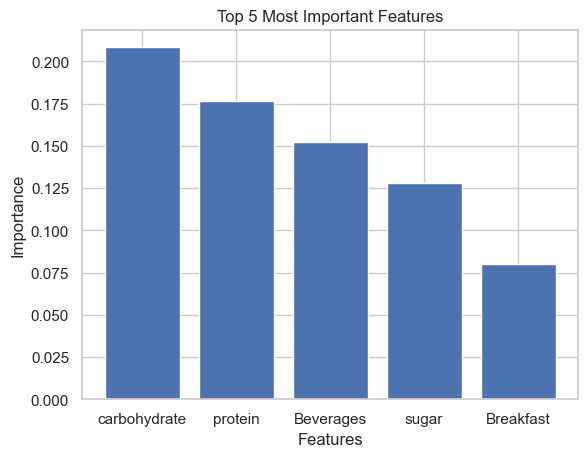

In [347]:
importance = Baseline_DT.feature_importances_
feature_names = X.columns

feature_importance = dict(zip(feature_names, importance))

top_5_features = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)[:5])

plt.bar(top_5_features.keys(), top_5_features.values())
plt.title('Top 5 Most Important Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


## Top 5 Features
It can be inferred that the most important features are the features that can make a recipe gains high traffic. This recipe with high traffic is very beneficial for Tasty Bytes as a recipe provider website as it can scope down what components (features) that can make a recipe gains high traffic.

The top 5 most important features that can make a recipe gains high traffic are **category**, **carbohydrate**, **sugar**, **protein**, and **calories**. The category can be scoped down even more to pin point user's most searched or viewed. As for the other features, those are nutritions and that showed that Tasty Bytes can make or publish recipes that have low carbohydrate, sugar, and calories but have high protein for weight loss diet.

## Business Needs (Key Performance Indicators)

Tasty Bytes wants me to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes.

The Key Performance Indicator (KPI) is **High Traffic Rate or Recall** which can be obtained by examining the **confusion matrix** and dividing the **TP** (True Positive) which indicate the "high traffic" recipe correctly classified as "high traffic" by the **FP** (False Positive) which indicate the "low traffic" recipe correctly classified as "high traffic" plus TP. So the formula is **TP/(TP+FP)**

I have set the KPI or the rata to be greater or equal than 80% as Tasty Bytes need me to predict which recipes will be popular 80% of the time.

In [348]:
print("Baseline Decision Tree")
print(cm_Baseline_DT)
print("High Traffic Rate/Recall: ", cm_Baseline_DT[0][0] / (cm_Baseline_DT[0][0] + cm_Baseline_DT[0][1]))
print("High Traffic Rate/Recall Percentage: {:.2%}".format(cm_Baseline_DT[0][0] / (cm_Baseline_DT[0][0] + cm_Baseline_DT[0][1])))

print("\nGrid Search CV Decision Tree")
print(cm_GridSearch_DT)
print("High Traffic Rate/Recall: ", cm_GridSearch_DT[0][0] / (cm_GridSearch_DT[0][0] + cm_GridSearch_DT[0][1]))
print("High Traffic Rate/Recall Percentage: {:.2%}".format(cm_GridSearch_DT[0][0] / (cm_GridSearch_DT[0][0] + cm_GridSearch_DT[0][1])))

print('-' * 40)

# Baseline SVM
print("Baseline SVM")
print(cm_Baseline_SVM)
print("High Traffic Rate/Recall: ", cm_Baseline_SVM[0][0] / (cm_Baseline_SVM[0][0] + cm_Baseline_SVM[0][1]))
print("High Traffic Rate/Recall Percentage: {:.2%}".format(cm_Baseline_SVM[0][0] / (cm_Baseline_SVM[0][0] + cm_Baseline_SVM[0][1])))

print("\nGrid Search CV SVM")
print(cm_GridSearch_SVM)
print("High Traffic Rate/Recall: ", cm_GridSearch_SVM[0][0] / (cm_GridSearch_SVM[0][0] + cm_GridSearch_SVM[0][1]))
print("High Traffic Rate/Recall Percentage: {:.2%}".format(cm_GridSearch_SVM[0][0] / (cm_GridSearch_SVM[0][0] + cm_GridSearch_SVM[0][1])))


Baseline Decision Tree
[[83 21]
 [25 42]]
High Traffic Rate/Recall:  0.7980769230769231
High Traffic Rate/Recall Percentage: 79.81%

Grid Search CV Decision Tree
[[91 13]
 [23 44]]
High Traffic Rate/Recall:  0.875
High Traffic Rate/Recall Percentage: 87.50%
----------------------------------------
Baseline SVM
[[89 15]
 [18 49]]
High Traffic Rate/Recall:  0.8557692307692307
High Traffic Rate/Recall Percentage: 85.58%

Grid Search CV SVM
[[89 15]
 [18 49]]
High Traffic Rate/Recall:  0.8557692307692307
High Traffic Rate/Recall Percentage: 85.58%


# Conclusion

For Tasty Bytes classification problem, I have created 2 baseline models and 2 models applied with Grid Search CV, those models are Decision Tree Classifier and SVM.

It can be inferred that based on the KPI, the Decision Tree Classifier model applied with Grid Search CV is the best model to use, followed by the baseline SVM and the SVM applied with Grid Search CV.

Overall, even though the Decision Tree Classifier model applied with Grid Search CV have lower accuracy score than the other model, but the Decision Tree Classifier model applied with Grid Search CV have better recall score which indicates that the model correctly identifying True Positives or correctly classifying data as high traffic.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation